In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
from scripts.going_modular import data_setup, engine

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [6]:
image_path = '../data/CombinedAll'
dest_dir = '../data/CombinedAll'
categories = ['Healthy', 'Patient']

# Create destination directories
for category in categories:
    os.makedirs(os.path.join(dest_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'test', category), exist_ok=True)

# Split and copy files
for category in categories:
    category_path = os.path.join(image_path, category)
    files = os.listdir(category_path)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(dest_dir, 'train', category, file))
    
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(dest_dir, 'test', category, file))

print("Dataset split into training and test sets successfully.")

Dataset split into training and test sets successfully.


In [7]:
from pathlib import Path

In [8]:
# Setup path to data folder
data_path = Path("../data/")
image_path = data_path / "CombinedAll"

In [9]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('../data/CombinedAll/train'),
 WindowsPath('../data/CombinedAll/test'))

In [10]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [11]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x20a8d894bc0>,
 ['Healthy', 'Patient'])

In [12]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x20a9540e5a0>,
 ['Healthy', 'Patient'])

In [15]:


# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Andakara/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:06<00:00, 3.21MB/s]


In [16]:
model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [18]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [20]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

In [21]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [22]:
# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results, all_preds, all_targets = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:57<03:48, 57.24s/it]

Epoch: 1 | train_loss: 0.5216 | train_acc: 0.7680 | test_loss: 0.4246 | test_acc: 0.8221


 40%|████      | 2/5 [01:34<02:15, 45.25s/it]

Epoch: 2 | train_loss: 0.4146 | train_acc: 0.8229 | test_loss: 0.3444 | test_acc: 0.8462


 60%|██████    | 3/5 [02:23<01:34, 47.20s/it]

Epoch: 3 | train_loss: 0.3616 | train_acc: 0.8523 | test_loss: 0.3080 | test_acc: 0.9038


 80%|████████  | 4/5 [03:02<00:44, 44.03s/it]

Epoch: 4 | train_loss: 0.3434 | train_acc: 0.8680 | test_loss: 0.2856 | test_acc: 0.9183


100%|██████████| 5/5 [03:29<00:00, 41.86s/it]

Epoch: 5 | train_loss: 0.3289 | train_acc: 0.8765 | test_loss: 0.2621 | test_acc: 0.9159
[INFO] Total training time: 209.337 seconds


[INFO] Couldn't find helper_functions.py, downloading...


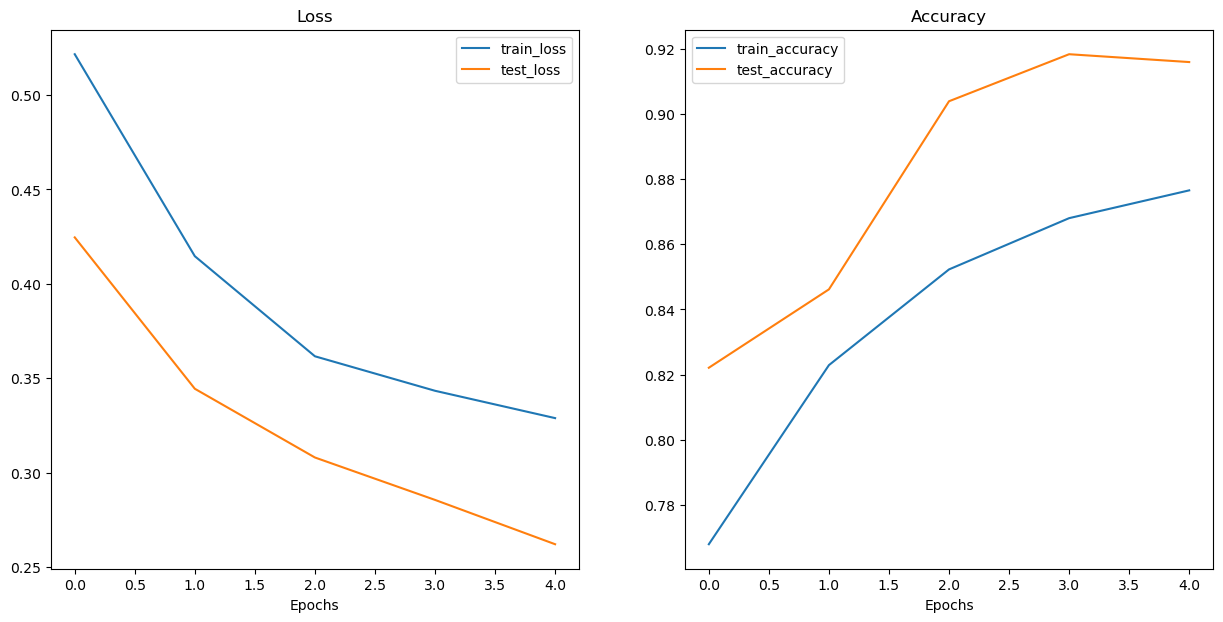

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [25]:
from typing import List, Tuple
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        true_class: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = torch.device('cpu')):
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.sigmoid() for binary classification)
    target_image_pred_probs = torch.sigmoid(target_image_pred)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = (target_image_pred_probs > 0.5).long()

    # 10. Plot image with predicted label, probability, true class, and image name
    plt.imshow(img)
    if class_names[target_image_pred_label] == true_class:
        plt.title(f"True: {true_class} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.item():.3f}", color="green")
    else:
        plt.title(f"True: {true_class} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.item():.3f}", color="red")
    plt.axis(False)

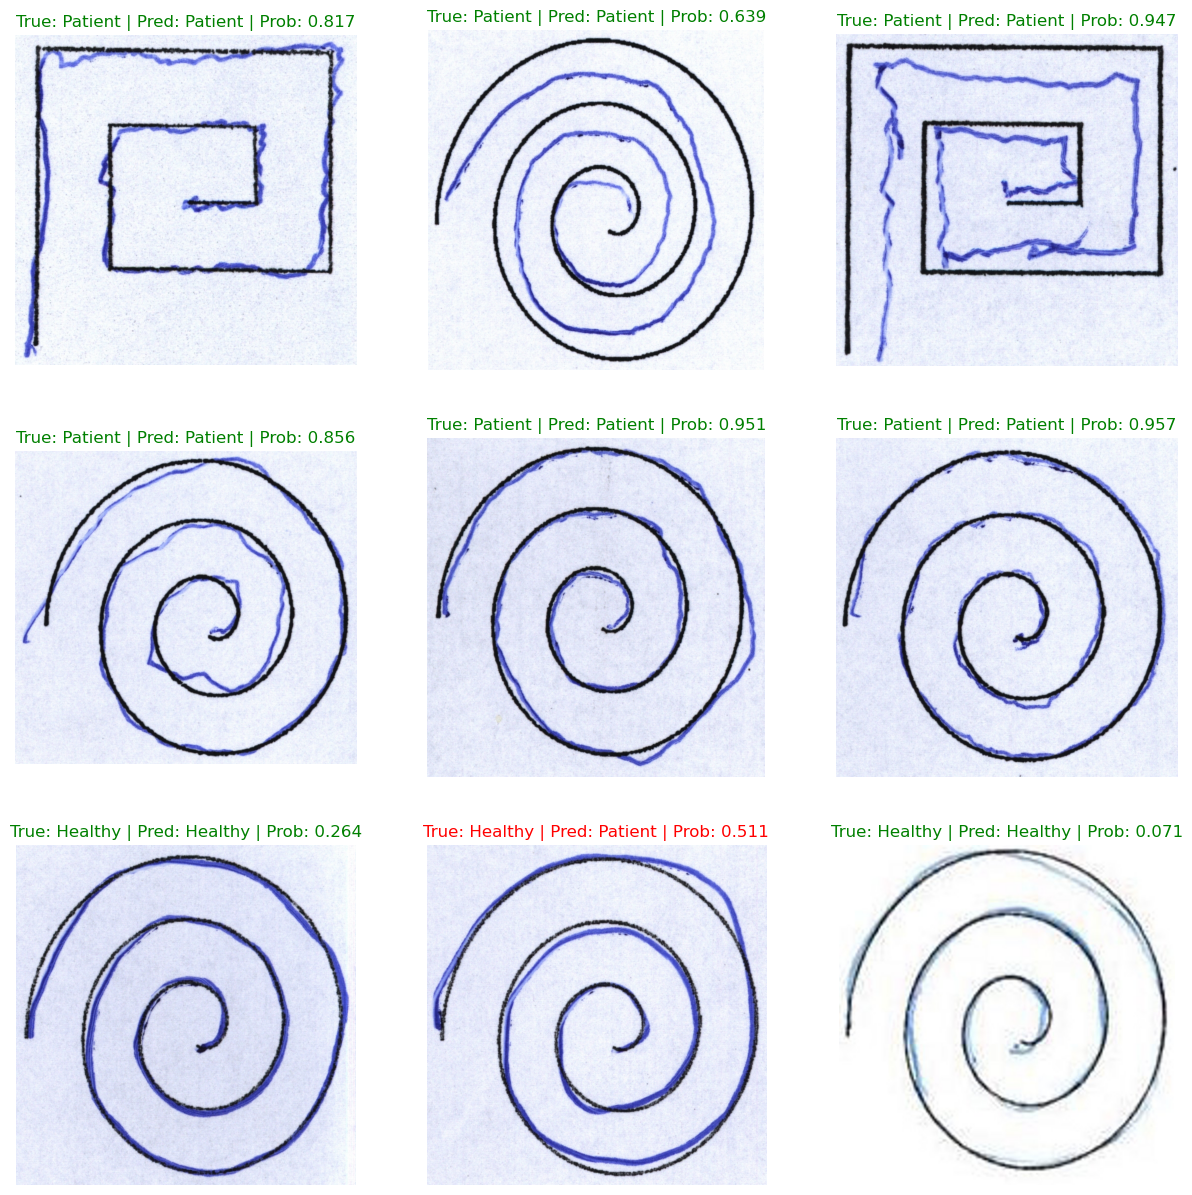

In [26]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 9
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images in a 3x3 grid
plt.figure(figsize=(15, 15))
for i, image_path in enumerate(test_image_path_sample):
    plt.subplot(3, 3, i + 1)
    true_class = image_path.parent.name
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        true_class=true_class,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))
plt.show()

In [27]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics mlxtend 
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [28]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [29]:
all_preds

[tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([0.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor([1.], device='cuda:0'),
 tensor(

In [30]:
import tqdm

In [31]:
device

'cuda'

In [32]:
test_preds = []
model.to(device)  # Move the model to the GPU
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm.tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.sigmoid(test_logits)

    # Convert the pred probs into pred labels (threshold at 0.5)
    pred_labels = (pred_probs > 0.5).int()

    # Add the pred labels to test preds list
    test_preds.append(pred_labels.cpu())

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


In [33]:
# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu().squeeze()
test_preds

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [34]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

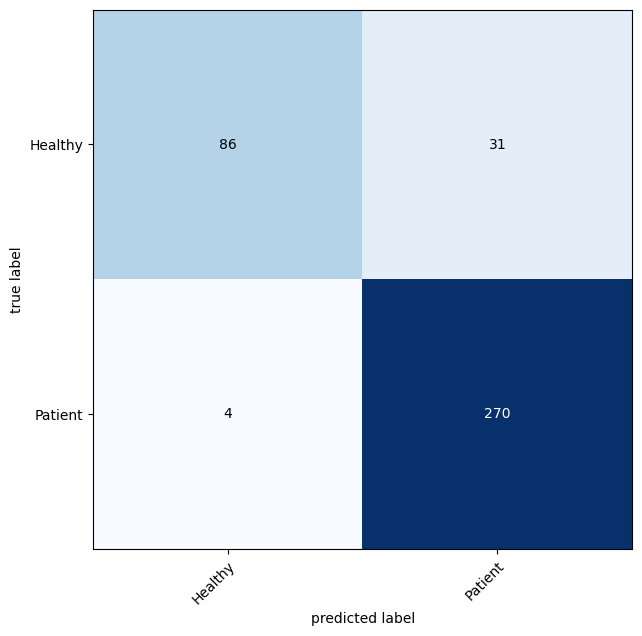

In [35]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task='binary', num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds, target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)